In [1]:
# test environment
import sys,os
import cityflow
import sumolib
sys.path.append('/home/jovyan/work/LibSignal')

### If **sumolib** import fail, execute the following cell

In [2]:
# %set_env SUMO_HOME=~/DaRL/sumo
# %set_env PYTHONPATH=~/DaRL/sum/tools:$PYTHONPATH
# sys.path.append('/home/jovyan/sumo')

# Overall framework of LibSignal project

<div align="center">
<img src="./images/overview.png" width="80%">
</div>

```
.
├── Dockerfile
├── README.md
├── agent
│   ├── {implemented agents}
    └── {your agents}
├── common
│   ├── converter.py
│   ├── interface.py
│   ├── metrics.py
│   ├── registry.py
│   └── utils.py
├── configs
│   ├── sim
│   ├── tsc
│   └── tscfx
├── data
│   └── raw_data
├── environment.py
├── generator
│   ├── base.py
│   ├── intersection_phase.py
│   ├── intersection_vehicle.py
│   └── lane_vehicle.py
├── run.py
├── task
│   └── task.py
├── trainer
├── utils
│   ├── logger.py
│   └── painter.py
└── world
    ├── world_cityflow.py
    └── world_sumo.py
```

## 1. How we achieved cross-simulator simulation with changable RL agents

``` python
class TSCEnv(gym.Env):
    """
    Environment for Traffic Signal Control task.
    world: World object
    agents: list of agents, corresponding to each intersection in world.intersections
    metric: Metric object, used to calculate evaluation metric
    """
    def __init__(self, world, agents, metric):
        # simulator component 
        self.world = world
        self.eng = self.world.eng
        
        # RL or rule-based agents
        self.agents = agents
        action_dims = [agent.action_space.n * agent.sub_agents for agent in agents]
        self.action_space = gym.spaces.MultiDiscrete(action_dims)

        # metric to evaluate agents' performance
        self.metric = metric

    def step(self, actions):
        # pass actions to simulator
        self.world.step(actions)
        # pass information to agents and record evaluation metrics
        obs = [agent.get_ob() for agent in self.agents]
        rewards = [agent.get_reward() for agent in self.agents]
        dones = [False] * self.n_agents
        return obs, rewards, dones, infos
```

<div align="left">
<img src="./images/decup.jpg" width="40%">
</div>

## 2. Alignment result of cross-simulator simualtion

<div align="center">
<img src="./images/Cologne1x1.png" width="80%">
</div>
<div align="center">
<img src="./images/hangzhou4x4.png" width="80%">
</div>

## 3. Current simulator support and planning simulator implementation

### 3.1. Implemented 
We currently implemented SUMO and Cityflow simulators, which cover 65% of recent publications in the traffic signal control domain (till July 2022). 
The simulatiors information could be retrived from [Cityflow](https://cityflow.readthedocs.io/en/latest/) and [SUMO](https://eclipse.dev/sumo/)

### 3.2. Future work
Our group is also considering implementing other simulations with more scalability and emerging in recent years studies including [CBLab](https://github.com/CaradryanLiang/CityBrainLab) and [CarLA](https://carla.org/)

***


# *more about : vissim, mobiliti*

# Quick start of LibSignal

In [3]:
# go to LibSignal directory
%cd ../LibSignal

/home/jovyan/work/LibSignal


In [1]:
标出颜色，高亮重要部分

SyntaxError: invalid character in identifier (1394569950.py, line 1)

To make demo runing faster, I set **epoch=20** in **base.yml** here. **Default setting is 200** in our experiment report.
```
.
└── configs
    ├── sim
    ├── tsc
    │    ├── base.yml
    │    └── ...
    └── tscfx

```

<div align="left">
<img src="./images/default.png" width="80%">
</div>

## 1. Only one step to start the simulation

In [4]:
# train 20 epoches here, default setting is 200 epoches
%run run.py

building world...
creating intersections...
intersections created.
parsing roads...
roads parsed.
world built.


KeyError: 'dqn_states'

## 2. Command line interface (CLI) and parameter settings


In [2]:
# Change agent to frap, simulator to cityflow and traffic network to hangzhou4x4

%run run.py -a frap -w cityflow -n cityflow1x1

building world...
creating intersections...
intersections created.
parsing roads...
roads parsed.
world built.
FRAP(
  (p): Embedding(2, 4)
  (d): Linear(in_features=1, out_features=4, bias=True)
  (lane_embedding): Linear(in_features=8, out_features=16, bias=True)
  (lane_conv): Conv2d(32, 20, kernel_size=(1, 1), stride=(1, 1))
  (relation_embedding): Embedding(2, 4)
  (relation_conv): Conv2d(4, 20, kernel_size=(1, 1), stride=(1, 1))
  (hidden_layer): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (before_merge): Conv2d(20, 1, kernel_size=(1, 1), stride=(1, 1))
)
2023-09-05 04:31:02 (INFO): step:3600/3600, q_loss:0, rewards:-21.397775607638888, queue:15.965104166666666, delay:0.12405602137247722, throughput:2458
2023-09-05 04:31:02 (INFO): episode:0/20, real avg travel time:697.9648005363728
2023-09-05 04:31:20 (INFO): Test step:0/20, travel time :1273.4327857861213, rewards:-57.362163628472224, queue:43.10503472222222, delay:0.18156378004286025, throughput:1662
2023-09-05 04:31:

# Navigation between different settings

In [ ]:
implemented states, how to add in states provided by user.

## 1. How can I change the state used in agent?
```
.
└── agent
    ├── dqn.py
    └── ...
```

### 1.1. Change state of DQN agent into *lane_pressure*
``` python
@Registry.register_model('dqn')
class DQNAgent(RLAgent):
    '''
    DQNAgent determines each intersection's action with its own intersection information.
    '''
    def __init__(self, world, rank):
        super().__init__(world, rank)
    
    # Change state generator in _create_generators
    def _create_generators(self):
        # self.ob_generator = LaneVehicleGenerator(self.world, self.inter_obj,
        #                                          ["lane_count"], in_only=True, average=None)
        super()._create_generators()
        self.ob_generator = LaneVehicleGenerator(self.world, self.inter_obj,
                                                 ["lane_pressure"], in_only=True, average=None)
```


### 1.2. Change state of DQN agent into list of states
``` python
@Registry.register_model('dqn')
class DQNAgent(RLAgent):
    '''
    DQNAgent determines each intersection's action with its own intersection information.
    '''
    def __init__(self, world, rank):
        super().__init__(world, rank)
    
    # Change state generator in _create_generators
    def _create_generators(self):
        # self.ob_generator = LaneVehicleGenerator(self.world, self.inter_obj,
        #                                          ["lane_count"], in_only=True, average=None)
        super()._create_generators()
        self.ob_generator = [LaneVehicleGenerator(self.world, self.inter_obj,
                                                 ["lane_pressure"], in_only=True, average=None),
                             LaneVehicleGenerator(self.world, self.inter_obj,
                                                 ["lane_count"], in_only=True, average=None)
        ]
```

In [5]:
%pwd

'/home/jovyan/work/LibSignal'

In [3]:
%run run.py -a dqn_states --prefix sss

building world...
creating intersections...
intersections created.
parsing roads...
roads parsed.
world built.


KeyError: 'dqn_states'

## 2. How can I change the reward used in agent?

```
.
└── agent
    ├── dqn.py
    └── ...
```
### 1.1. Change reward of DQN agent into *pressure*
``` python
def _create_generators(self):
    super()._create_generators()
    # self.reward_generator = LaneVehicleGenerator(self.world, self.inter_obj,
    self.reward_generator = LaneVehicleGenerator(self.world, self.inter_obj,
                                                 ["pressure"], 
                                                 in_only=True,average="all",
                                                 negative=True)
```

In [5]:
%run run.py

FileNotFoundError: [Errno 2] No such file or directory: './configs/tsc/dqn-states.yml'

## 3. How can I change the action used in agent?

### 3.1. Base class of flexible traffic signal control (tscfx)

To control phase and duration at the same time, user should change -task argument into **"tscfx"** and assign agents inherent from Base class **RLFXAgent**.

```
.
├── agent
│   ├── rlfx_agent.py
│   └── ...
├── configs
│   ├── tscfx
│   │    ├──rlfx.yml
│   │    └── ...
└── trainer
    ├── tscfx_trainer.py
    └── ...
```

**RLFXAgent** should have *duration_units*/ *duration_unit* and *duration_spaces*/ *duration_spaces* and *duration_min*, because these parameters tells agents the duration action space.
<div align="left">
<img src="./images/actions.png" width="80%">
</div>


We provide a flexible agent with fixed duration action space, users could build their own agent upon it.

In [2]:
%run run.py -t tscfx -a rlfx

building world...
creating intersections...
intersections created.
parsing roads...
roads parsed.
world built.
2023-09-04 20:09:11 (INFO): Final Travel Time is 653.1331, mean rewards: -13.7678, queue: 110.4042, delay: 0.6896, throughput: 1390
2023-09-04 20:09:11 (INFO): Total time taken: 3.7486133575439453


## 4. What if I want to use another simulator?

In [3]:
%run run.py -w sumo -n sumohz1x1

building world...
Connection ID hangzhou_1x1_bc-tyc_18041610_1h-debug
DQNNet(
  (dense_1): Linear(in_features=16, out_features=20, bias=True)
  (dense_2): Linear(in_features=20, out_features=20, bias=True)
  (dense_3): Linear(in_features=20, out_features=8, bias=True)
)
2023-09-05 02:59:50 (INFO): step:3600/3600, q_loss:0, rewards:-136.08446180555555, queue:128.80555555555554, delay:0.6749879625108507, throughput:1085
2023-09-05 02:59:50 (INFO): episode:0/200, real avg travel time:880.3681345868382
2023-09-05 02:59:53 (INFO): Test step:0/200, travel time :1025.7199406234538, rewards:-123.77724609375, queue:116.45555555555555, delay:0.6642103830973307, throughput:801
2023-09-05 02:59:56 (INFO): step:3600/3600, q_loss:0, rewards:-127.62447916666666, queue:119.69722222222222, delay:0.6544515397813585, throughput:1192
2023-09-05 02:59:56 (INFO): episode:1/200, real avg travel time:720.0959920831272


KeyboardInterrupt: 

***

# How to visualize simulation results?

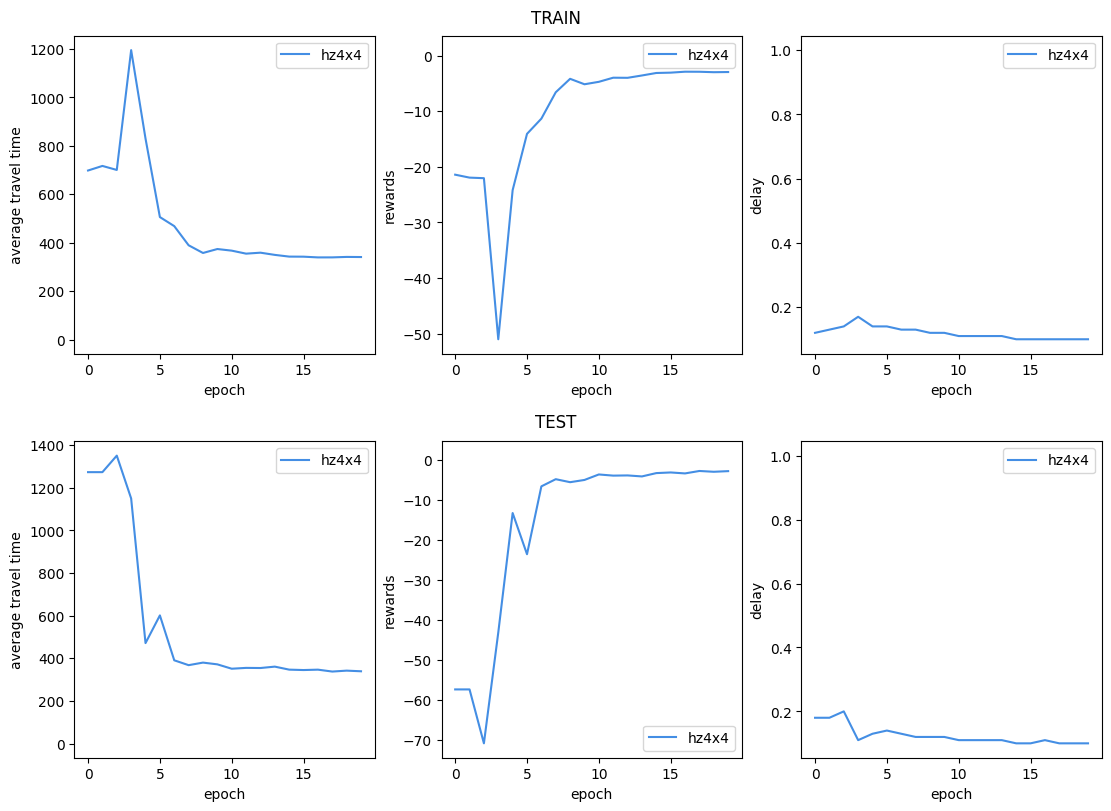

In [5]:
from utils.paint import painter
cityflow_4x4 = '/home/jovyan/work/LibSignal/data/output_data/tsc/cityflow_frap/cityflow4x4/test/logger/2023_09_05-04_30_50_DTL.log'
painter({'hz4x4': cityflow_4x4}, ['epoch', 'average travel time', 'rewards','delay'])

# How to contribute to our LibSignal project?